# Melhor resultado obtido

In [1]:
import numpy as np
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()
import scipy.io
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping

Instructions for updating:
non-resource variables are not supported in the long term


# 1. Recolher dados

In [2]:
def get_upper_triang(arr):
    upper_triang = []
    for i in range(len(arr)):
        for j in range(len(arr)):
            if (j > i):
                upper_triang.append(arr[i][j])
                
    return np.array(upper_triang)

def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    print(train_mat.keys())
    print(test_mat.keys())
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    '''train_np_upper_triang = []
    for i in range(len(train_np)):
        train_np_upper_triang.append(get_upper_triang(train_np[i]))
    train_np_upper_triang = np.array(train_np_upper_triang)
    test_np_upper_triang = []
    for i in range(len(test_np)):
        test_np_upper_triang.append(get_upper_triang(test_np[i]))
    test_np_upper_triang = np.array(test_np_upper_triang)
    train_np = train_np_upper_triang
    test_np = test_np_upper_triang'''
    print('Train shape: ',train_np.shape)
    print('Test shape: ',test_np.shape)
    return  train_np, test_np

train_data, test_data = get_data_from_mat('train_data.mat','test_data.mat')

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data'])
Train shape:  (112, 90, 90)
Test shape:  (28, 90, 90)


In [3]:
train_data[0]

array([[0.        , 0.        , 0.13152513, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13152513, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.28060623],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.28060623, 0.        ,
        0.        ]])

# 2. Preparar os datasets de treino e de teste

In [4]:
print(train_data.shape)
train_data = train_data.reshape(112,8100)
train_data.shape

(112, 90, 90)


(112, 8100)

In [5]:
print(test_data.shape)
test_data = test_data.reshape(28,90*90)
test_data.shape

(28, 90, 90)


(28, 8100)

## 2.1. Adicionar mais informação da literacia

In [6]:
TRAIN_CSV_PATH = 'train.csv'
TEST_CSV_PATH = 'test.csv'
rest_train_df = pd.read_csv(TRAIN_CSV_PATH)
rest_train_df.head(10) #Tem 112 linhas

,id,age,sex,education
0,1,13,1,7
1,2,14,0,8
2,3,15,1,9
3,4,15,1,9
4,5,15,1,9
5,6,15,1,9
6,7,16,0,10
7,8,16,1,10
8,9,16,0,10
9,10,17,0,11


In [7]:
rest_test_df = pd.read_csv(TEST_CSV_PATH)
rest_test_df.head(10) #Tem 28 linhas

,id,sex,education
0,1,0,13
1,2,0,11
2,3,1,9
3,4,1,13
4,5,0,12
5,6,0,17
6,7,0,9
7,8,0,4
8,9,1,9
9,10,1,4


In [8]:
def normalize(X):
    Xmax = np.max(X, axis = 0)
    Xmin = np.min(X, axis = 0)
    return (X-Xmin)/(Xmax-Xmin)

targets_train = rest_train_df['age']
education_train = normalize(rest_train_df['education'])
sex_train = rest_train_df['sex'].astype('float32')
education_test = normalize(rest_test_df['education'])
sex_test = rest_test_df['sex'].astype('float32')

In [9]:
#Juntar o resto à conectividade
train_df_all = pd.DataFrame(train_data)
train_df_all['education'] = education_train
train_df_all['sex'] = sex_train
train_df_all['age'] = targets_train
train_df_all

,0,1,2,3,4,5,6,7,8,9,...,8093,8094,8095,8096,8097,8098,8099,education,sex,age
0,0.0,0.0,0.131525,0.0,0.0,0.0,0.271538,0.0,0.0,0.0,...,0.000000,0.0,0.585006,0.0,0.280606,0.0,0.0,0.35,1.0,13
1,0.0,0.0,0.117704,0.0,0.0,0.0,0.316890,0.0,0.0,0.0,...,0.000000,0.0,0.599437,0.0,0.207478,0.0,0.0,0.40,0.0,14
2,0.0,0.0,0.155806,0.0,0.0,0.0,0.348072,0.0,0.0,0.0,...,0.000000,0.0,0.630374,0.0,0.246472,0.0,0.0,0.45,1.0,15
3,0.0,0.0,0.145214,0.0,0.0,0.0,0.310270,0.0,0.0,0.0,...,0.000000,0.0,0.562505,0.0,0.287888,0.0,0.0,0.45,1.0,15
4,0.0,0.0,0.161360,0.0,0.0,0.0,0.385560,0.0,0.0,0.0,...,0.000000,0.0,0.564043,0.0,0.234284,0.0,0.0,0.45,1.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.0,0.0,0.215767,0.0,0.0,0.0,0.390332,0.0,0.0,0.0,...,0.011150,0.0,0.660292,0.0,0.302675,0.0,0.0,0.20,1.0,77
108,0.0,0.0,0.143005,0.0,0.0,0.0,0.306380,0.0,0.0,0.0,...,0.019141,0.0,0.630415,0.0,0.204125,0.0,0.0,0.20,0.0,67
109,0.0,0.0,0.116085,0.0,0.0,0.0,0.290941,0.0,0.0,0.0,...,0.000000,0.0,0.574355,0.0,0.246784,0.0,0.0,0.20,0.0,55
110,0.0,0.0,0.156654,0.0,0.0,0.0,0.357540,0.0,0.0,0.0,...,0.000000,0.0,0.631057,0.0,0.216259,0.0,0.0,0.15,1.0,76


In [10]:
#Juntar o resto à conectividade
test_df_all = pd.DataFrame(test_data)
test_df_all['education'] = education_test
test_df_all['sex'] = sex_test
test_df_all

,0,1,2,3,4,5,6,7,8,9,...,8092,8093,8094,8095,8096,8097,8098,8099,education,sex
0,0.0,0.0,0.140891,0.000000,0.0,0.0,0.332442,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.612109,0.0,0.193069,0.0,0.0,0.764706,0.0
1,0.0,0.0,0.147297,0.000000,0.0,0.0,0.326313,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.635466,0.0,0.275949,0.0,0.0,0.647059,0.0
2,0.0,0.0,0.091724,0.000000,0.0,0.0,0.338758,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.577096,0.0,0.260915,0.0,0.0,0.529412,1.0
3,0.0,0.0,0.095972,0.000000,0.0,0.0,0.308292,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.535117,0.0,0.198058,0.0,0.0,0.764706,1.0
4,0.0,0.0,0.129573,0.000000,0.0,0.0,0.337631,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.590000,0.0,0.266638,0.0,0.0,0.705882,0.0
5,0.0,0.0,0.142985,0.000000,0.0,0.0,0.350861,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.702736,0.0,0.267522,0.0,0.0,1.000000,0.0
6,0.0,0.0,0.131228,0.000000,0.0,0.0,0.309908,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.612072,0.0,0.282661,0.0,0.0,0.529412,0.0
7,0.0,0.0,0.101044,0.000000,0.0,0.0,0.337020,0.0,0.0,0.0,...,0.0,0.014537,0.0,0.611550,0.0,0.291660,0.0,0.0,0.235294,0.0
8,0.0,0.0,0.230942,0.000000,0.0,0.0,0.409840,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.608007,0.0,0.278882,0.0,0.0,0.529412,1.0
9,0.0,0.0,0.134479,0.000000,0.0,0.0,0.278180,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.633834,0.0,0.284398,0.0,0.0,0.235294,1.0


In [15]:
x_train = train_df_all.values[:,:8102]
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(train_df_all.values[:,8102].astype(int))
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  random_state = 2022, 
                                                  test_size=0.22)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_train)

(87, 8102)
(25, 8102)
(87,)
[44 40 21 28 30 29 17  2 39  6 41 34  1  5  5  3 18 11 38  3  4 25  7 39
 16 22 15 35 30 11 26  3 13 41 32 10 35  0 41 46 10 45 27  8 33 36 32 47
 38 29  6  9  2 23 38 45  3 24 14 32  5  2 22  2 39 33  3 42 10 44 20 43
 28 10  3 11  5  6 11  4 12  3 33 31  9 13 45]


In [16]:
x_train = np.expand_dims(x_train,axis=2)
x_val = np.expand_dims(x_val,axis=2)
x_test = np.expand_dims(test_df_all.values[:,:],axis=2)
print(x_train.shape)
print(x_test.shape)

(87, 8102, 1)
(28, 8102, 1)


# 3. Definir o modelo

In [13]:
inputs = tf.keras.Input(shape=(8102,1))
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.MaxPool1D()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mae',
    metrics =  ['mae']
)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8102, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 8100, 32)          128       
                                                                 
 dropout (Dropout)           (None, 8100, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4050, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dense (Dense)               (None, 32)                4147232   
                                                             

In [15]:
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('final_model.h5', verbose=1, save_best_only=True)

def fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size):
    actual_model = None
    actual_model = model
    results = model.fit(t_x, t_y, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint, PlotLossesCallback()], 
              verbose=1, validation_split=0.2)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

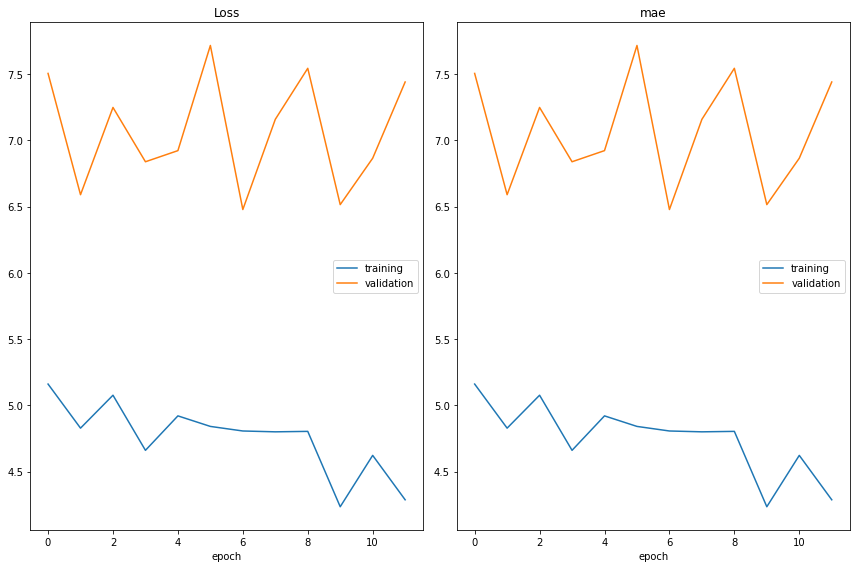

Loss
	training         	 (min:    4.234, max:    5.160, cur:    4.287)
	validation       	 (min:    6.477, max:    7.716, cur:    7.440)
mae
	training         	 (min:    4.234, max:    5.160, cur:    4.287)
	validation       	 (min:    6.477, max:    7.716, cur:    7.440)
4/4 [==============================] - 1s 265ms/step - loss: 4.2865 - mae: 4.2865 - val_loss: 7.4400 - val_mae: 7.4400
Epoch 12: early stopping
1/1 [==============================] - 0s 43ms/step - loss: 6.6111 - mae: 6.6111
Val Score:  [6.611119747161865, 6.611119747161865]




In [16]:
n_folds=3
epochs=30
batch_size=16

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = 2022)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

# 4. Avaliar o modelo

In [17]:
model = keras.models.load_model('final_model.h5')
model.evaluate(x_val, y_val)

1/1 [==============================] - 0s 151ms/step - loss: 5.8959 - mae: 5.8959


[5.895900249481201, 5.895900249481201]

In [18]:
final_model = keras.models.load_model('final_model.h5')

preds = final_model.predict(x_test)
preds = [int(age) for age in preds]
preds = le.inverse_transform(preds)
print(preds)

with open('test_submission.csv', 'w', encoding='UTF8', newline='') as f:
    count_id = 1
    writer = csv.writer(f)
    writer.writerow(['id','age'])
    for age in preds:
        line = [count_id, age]
        writer.writerow(line)
        count_id += 1

[24 21 21 24 20 20 64 56 61 64 67 67 71 65 21 27 22 31 26 28 62 57 65 74
 65 66 63 63]


# 5. Shap values

In [56]:
print(x_val.shape)
print(y_val.shape)

x_val = x_val.reshape(25,8102)
x_train = x_train.reshape(87,8102)

x_val_df = pd.DataFrame(x_val)
x_train_df = pd.DataFrame(x_train)

(25, 8102)
(25,)


## 5.1. Primeira linha do dataset

In [66]:
prediction = final_model.predict(x_val[[0]])
prediction = int(prediction)
prediction = le.inverse_transform([prediction])
print('Previsão:',prediction[0])

Previsão: 53


In [21]:
import shap

shap.initjs()

In [58]:
x_train_summary = shap.kmeans(x_train_df, 30)

explainer = shap.KernelExplainer(final_model.predict, x_train_summary)
shap_values = explainer.shap_values(x_val_df.iloc[0])

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [59]:
shap.force_plot(explainer.expected_value, shap_values[0], x_val_df.iloc[0,:])

In [85]:
#Inverse transform the encoding
real_value = le.inverse_transform([int(24.17)])[0]
print('Previsão:',real_value)

#Posição 155 do array 1d influencia mais esta decisão
#Posição 7828 influencia negativamente esta decisão
linha_2d = int(155 / 90)
coluna_2d = 155 % 90

linha_2d_2 = int(7828 / 90)
coluna_2d_2 = 7828 % 90

print('pos 155 corresponde a (',linha_2d,',',coluna_2d,') em 2d e pos 7828 corresponde a ('
      ,linha_2d_2,',',coluna_2d_2,') em 2d')

print('As conexões que mais influenciam a previsão desta idade são a 2-65 e 87-89')
print('Isto corresponde à ligação entre a zona Precentral_R com Angular_L' +
      ' e Temporal_Pole_Mid_L com Temporal_Inf_L, respetivamente')

Previsão: 53
pos 155 corresponde a ( 1 , 65 ) em 2d e pos 7828 corresponde a ( 86 , 88 ) em 2d
As conexões que mais influenciam a previsão desta idade são a 2-65 e 87-89
Isto corresponde à ligação entre a zona Precentral_R com Angular_L e Temporal_Pole_Mid_L com Temporal_Inf_L, respetivamente


## 5.2. Quinta linha do dataset

In [64]:
prediction = final_model.predict(x_val[[4]])
prediction = int(prediction)
prediction = le.inverse_transform([prediction])
print('Previsão:',prediction[0])

Previsão: 67


In [67]:
shap_values = explainer.shap_values(x_val_df.iloc[4])

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [68]:
shap.force_plot(explainer.expected_value, shap_values[0], x_val_df.iloc[4,:])

In [87]:
#Inverse transform the encoding
real_value = le.inverse_transform([int(37.13)])[0]
print('Previsão:',real_value)

#Posição 6821 do array 1d influencia mais esta decisão
linha_2d = int(6821 / 90)
coluna_2d = 6821 % 90

print('pos 6821 corresponde a (',linha_2d,',',coluna_2d,') em 2d')

print('As conexões que mais influenciam a previsão desta idade são a 76-72')
print('Isto corresponde à ligação entre a zona Pallidum_R e Caudate_R')

Previsão: 67
pos 6821 corresponde a ( 75 , 71 ) em 2d
As conexões que mais influenciam a previsão desta idade são a 76-72
Isto corresponde à ligação entre a zona Pallidum_R e Caudate_R
